In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [51]:
df = pd.read_csv('Cleaned Data for ML.csv')

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 45 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   deposit                                 2201 non-null   float64
 1   energy_rating                           2201 non-null   int64  
 2   living_area_m2                          2201 non-null   float64
 3   number_of_bathrooms                     2201 non-null   int64  
 4   number_of_rooms                         2201 non-null   int64  
 5   price                                   2201 non-null   float64
 6   offer_to_available                      2201 non-null   float64
 7   house_age                               2201 non-null   float64
 8   balcony_Not present                     2201 non-null   bool   
 9   balcony_Present                         2201 non-null   bool   
 10  city_Amsterdam                          2201 non-null   bool

# Split and transform data

In [53]:
# Split the data for the common use
from sklearn.model_selection import train_test_split
X = df.drop(columns = ['price']).copy()
y = df['price'].copy()
# split data to train + test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [54]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Step 1: Log-transform specific numeric columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).drop(
    columns=['energy_rating', 'price', 'number_of_bathrooms', 'number_of_rooms', 'house_age']
).columns

for c in numeric_columns:
    X_train[c] = np.log1p(X_train[c])  # Use log1p to handle zero values safely
    X_test[c] = np.log1p(X_test[c])

# Step 2: Shift and log-transform 'house_age'
dfs = {'X_train': X_train, 'X_test': X_test}  # Use dictionary for better management
shift_age_value = abs(X_train['house_age'].min()) + 1  # Calculate shift value from training data

for name, d in dfs.items():
    d['house_age'] = np.log1p(d['house_age'] + shift_age_value)  # Apply consistent transformation

# Step 3: Transform 'number_of_rooms' with square root and scale
scaler_rooms = StandardScaler()  # Initialize one scaler for consistent scaling
X_train['number_of_rooms'] = scaler_rooms.fit_transform(np.sqrt(X_train[['number_of_rooms']]))
X_test['number_of_rooms'] = scaler_rooms.transform(np.sqrt(X_test[['number_of_rooms']]))

# Step 4: Transform target variable (if needed for modeling)
y_train = np.log1p(y_train)  # Log-transform the target variable
y_test = np.log1p(y_test)



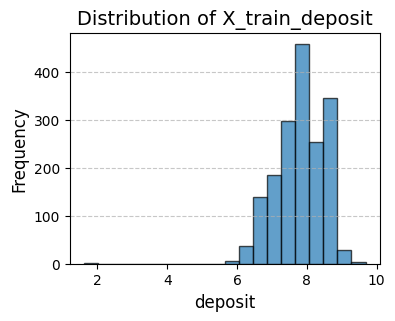

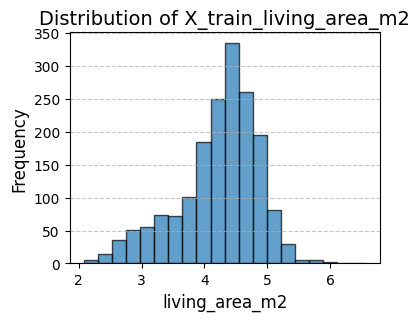

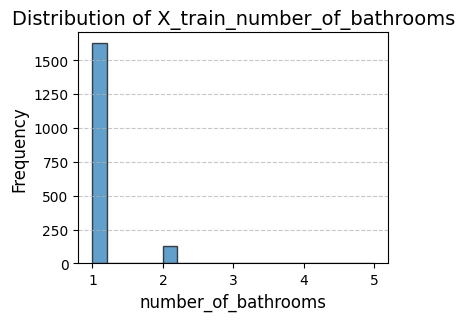

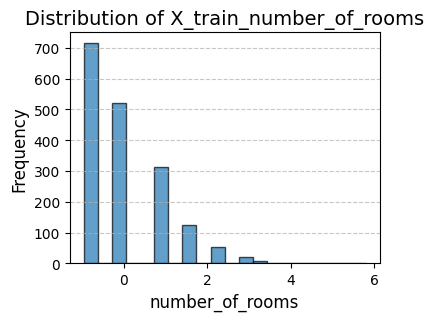

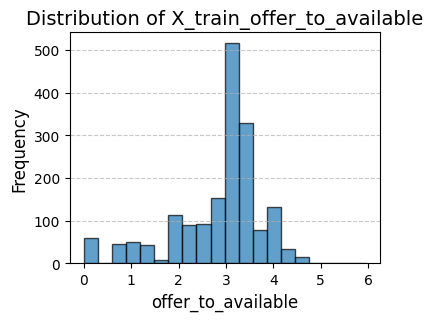

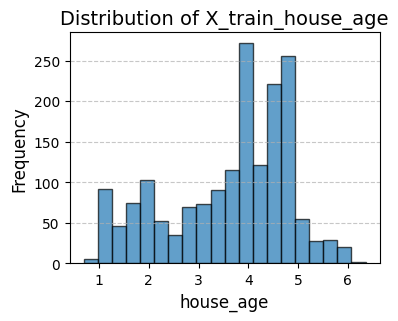

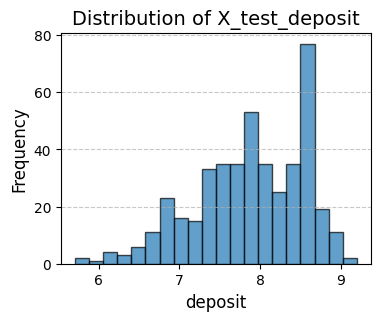

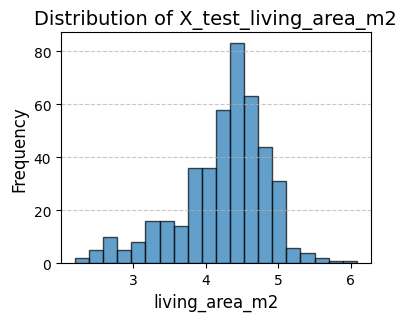

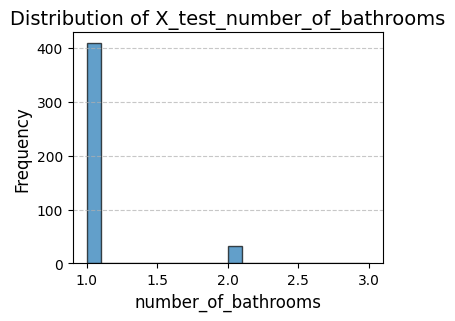

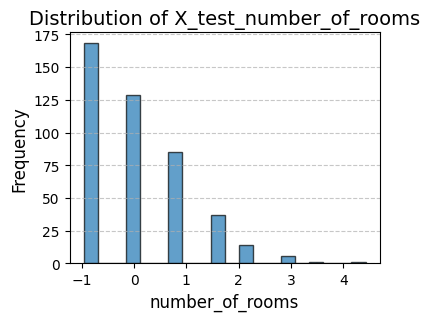

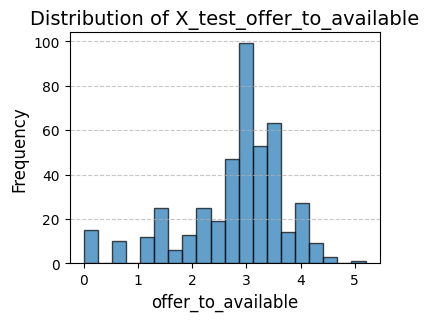

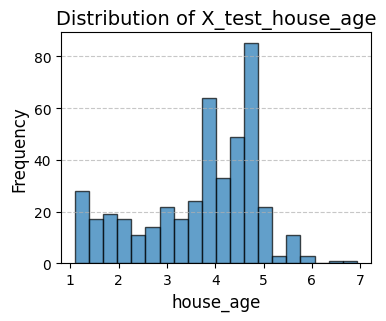

In [55]:
dfs = {'X_train': X_train, 'X_test': X_test}  # Use a dictionary to associate names with DataFrames
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).drop(columns=['energy_rating']).columns

for name, d in dfs.items():  # Iterate through the dictionary
    for column in numeric_columns:
        plt.figure(figsize=(4, 3))  # Set figure size
        plt.hist(d[column].dropna(), bins=20, edgecolor='k', alpha=0.7)  # Drop NaNs and plot histogram
        plt.xlabel(column, fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title(f'Distribution of {name}_{column}', fontsize=14)
        plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add gridlines
        plt.show()


# ML models

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import shap

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Adj r2 = 1-(1-R2)*(n-1)/(n-p-1)

def result(alg_model, X_test, y_test):
  y_pred = alg_model.predict(X_test)
  r2 = r2_score(y_test, y_pred)
  n = len(y_test)
  p = len(X_test.columns)
  adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
  print('Mean Absolute Error: {}\n\nMean Squared Error:\n {}\n\nR-Squared: {}\n\nAdjusted R-Squared:\n {}'
      .format(mean_absolute_error(y_test,y_pred), mean_squared_error(y_test,y_pred),r2_score(y_test, y_pred),adj_r2))
def gridCVModel(algorithm, X_train, y_train, grid):
  # https://www.projectpro.io/recipes/find-optimal-parameters-using-randomizedsearchcv-for-regression
  # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
  # https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
  scoring = {'Negative Mean Absolute Error':'neg_mean_absolute_error','Negative Mean Squared Error':'neg_mean_squared_error', 'R-Squared':'r2'}
  randm_src = RandomizedSearchCV(estimator=algorithm, param_distributions = grid, cv = 5, n_iter = 10, n_jobs=-1,
                                 scoring = scoring,refit='Negative Mean Absolute Error', random_state = 42)
  randm_src.fit(X_train, y_train)

  print(" Results from Random Search " )
  print("\n The best estimator across ALL searched params:\n", randm_src.best_estimator_)
  print("\n The best score across ALL searched params:\n", randm_src.best_score_)
  print("\n The best parameters across ALL searched params:\n", randm_src.best_params_)
  # Calculate and print scores for the best estimator
  best_estimator = randm_src.best_estimator_
  for score_name, score_func in scoring.items():
      score = cross_val_score(best_estimator, X_train, y_train, cv=5, scoring=score_func)
      print(f"\n {score_name} score for the best estimator: {score.mean()}")


def model(algorithm, X_train, X_test, y_train, y_test):
  # Evaluate the model
  alg_model = algorithm.fit(X_train, y_train)
  result(alg_model, X_test, y_test)
  parameters = alg_model.get_params()
  print(f"Parameters of the model: {parameters}")

## Linear Regression

In [58]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
print('Linear Regression Model \n')
model(reg, X_train, X_test, y_train, y_test)

Linear Regression Model 

Mean Absolute Error: 0.16231475700826278

Mean Squared Error:
 0.046648265377498124

R-Squared: 0.8483081749070298

Adjusted R-Squared:
 0.8314535276744776
Parameters of the model: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}


## Ridge Model

In [59]:
from sklearn.linear_model import Ridge
ridge = Ridge()

alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver = ['auto', 'svd', 'cholesky', 'lsqr']
fit_intercept = [True]
tol = [1e-4, 1e-3, 1e-2] 

random_grid = {'alpha': alpha,
               'solver': solver,
               'fit_intercept': fit_intercept,
               'tol': tol}

gridCVModel(ridge, X_train, y_train, random_grid)


 Results from Random Search 

 The best estimator across ALL searched params:
 Ridge(alpha=0.01)

 The best score across ALL searched params:
 -0.16943323612111005

 The best parameters across ALL searched params:
 {'tol': 0.0001, 'solver': 'auto', 'fit_intercept': True, 'alpha': 0.01}

 Negative Mean Absolute Error score for the best estimator: -0.16943323612111005

 Negative Mean Squared Error score for the best estimator: -0.05232613502843193

 R-Squared score for the best estimator: 0.8314955368145001


In [60]:
print("Ridge model test performance:\n")
ridge_tuned = Ridge(tol = 0.001, solver = 'lsqr', fit_intercept = True, alpha = 0.01)
model(ridge_tuned, X_train, X_test, y_train, y_test)

Ridge model test performance:

Mean Absolute Error: 0.1620875134840827

Mean Squared Error:
 0.04658636432522189

R-Squared: 0.8485094660701411

Adjusted R-Squared:
 0.831677184522379
Parameters of the model: {'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'lsqr', 'tol': 0.001}


## Decision Tree

In [61]:
from sklearn.tree import DecisionTreeRegressor

#
tree = DecisionTreeRegressor(random_state = 42)

# The maximum depth of the tree.
max_depth = np.arange(3, 16, 2).tolist()
# The minimum number of samples required to split an internal node:
min_samples_split = np.linspace(2, 10, num=5, dtype=int).tolist()
# The minimum number of samples required to be at a leaf node
min_samples_leaf = np.array([1, 2, 3, 5]).tolist()
# The number of features to consider when looking for the best split:
max_features = [None, 'sqrt', 'log2']
# A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
min_impurity_decrease = [0, 0.001, 0.01, 0.1]
# Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
max_leaf_nodes = np.linspace(10, 50, num=5, dtype=int).tolist()
# The function to measure the quality of a split.
criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']


random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features,
               'min_impurity_decrease': min_impurity_decrease,
               'max_leaf_nodes': max_leaf_nodes,
               'criterion': criterion}

gridCVModel(tree, X_train, y_train, random_grid)

 Results from Random Search 

 The best estimator across ALL searched params:
 DecisionTreeRegressor(criterion='friedman_mse', max_depth=15, max_leaf_nodes=30,
                      min_impurity_decrease=0.001, min_samples_leaf=5,
                      random_state=42)

 The best score across ALL searched params:
 -0.18758521947312673

 The best parameters across ALL searched params:
 {'min_samples_split': 2, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 30, 'max_features': None, 'max_depth': 15, 'criterion': 'friedman_mse'}

 Negative Mean Absolute Error score for the best estimator: -0.18758521947312673

 Negative Mean Squared Error score for the best estimator: -0.06290174069264817

 R-Squared score for the best estimator: 0.7975839244755732


In [62]:
print("Decision Tree Test Performance:\n")
tree_tuned = DecisionTreeRegressor(random_state = 42, min_samples_split= 2, min_samples_leaf = 5, min_impurity_decrease= 0.001, 
                                   max_leaf_nodes= 30, max_features= None, max_depth= 15, criterion = 'friedman_mse' )
model(tree_tuned, X_train, X_test, y_train, y_test)

Decision Tree Test Performance:

Mean Absolute Error: 0.18352266969691952

Mean Squared Error:
 0.059991659792875796

R-Squared: 0.8049178401234272

Adjusted R-Squared:
 0.7832420445815858
Parameters of the model: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'max_depth': 15, 'max_features': None, 'max_leaf_nodes': 30, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


## Random Forest

In [63]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)

# Number of trees
n_estimators = [50, 100, 200, 500, 1000]
# tree depth
max_depth = [None, 5, 10, 20, 50]
# minimum samples to split
min_samples_split = [2, 5, 10, 20]
# minimum samples per leaf
min_samples_leaf = [1, 2, 5, 10]
# Features for splits
max_features = ['sqrt', 'log2', None, 0.5, 0.8]
# Bootstrapping
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 
               'min_samples_leaf': min_samples_leaf, 'max_features': max_features, 'bootstrap': bootstrap}

gridCVModel(rf, X_train, y_train, random_grid)

 Results from Random Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(bootstrap=False, max_depth=10, max_features=0.5,
                      min_samples_leaf=5, min_samples_split=10,
                      n_estimators=200, random_state=42)

 The best score across ALL searched params:
 -0.14847484147649867

 The best parameters across ALL searched params:
 {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 0.5, 'max_depth': 10, 'bootstrap': False}

 Negative Mean Absolute Error score for the best estimator: -0.14847484147649867

 Negative Mean Squared Error score for the best estimator: -0.043559615893619015

 R-Squared score for the best estimator: 0.8601414217906644


In [64]:
print('Random Forest Test Performance:\n')
rf_tuned = RandomForestRegressor(random_state= 42, n_estimators = 200, min_samples_split = 10, min_samples_leaf = 5,
                        max_features = 0.5, max_depth = 10, bootstrap = False)

model(rf_tuned, X_train, X_test, y_train, y_test)


Random Forest Test Performance:

Mean Absolute Error: 0.14280771983289284

Mean Squared Error:
 0.03952536281686879

R-Squared: 0.8714705814968031

Adjusted R-Squared:
 0.8571895349964479
Parameters of the model: {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 0.5, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


## Gradient Boosting Regressor

In [67]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state = 42)

# The number of boosting stages (trees)
n_estimators = [50, 100, 200, 300, 500]
# Controls the contribution of each tree to the final prediction
learning_rate = [0.01, 0.05, 0.1, 0.2]
# The maximum depth of each decision tree
max_depth = [3, 5, 7, 10]
# Minimum number of samples required to be in a leaf node
min_samples_split = [2, 5, 10, 20]
# The number of features to consider when looking for the best split
max_features = [None, 'sqrt', 'log2', 0.5, 0.8]
# The fraction of samples used for training each tree
subsample = [0.6, 0.8, 1.0]

random_grid = {'n_estimators': n_estimators, 'learning_rate': learning_rate, 'max_depth': max_depth,
               'min_samples_split': min_samples_split, 'max_features': max_features, 'subsample': subsample}


gridCVModel(gbr, X_train, y_train, random_grid)


 Results from Random Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.05, max_depth=5, max_features=0.5,
                          random_state=42)

 The best score across ALL searched params:
 -0.1476949286556423

 The best parameters across ALL searched params:
 {'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 2, 'max_features': 0.5, 'max_depth': 5, 'learning_rate': 0.05}

 Negative Mean Absolute Error score for the best estimator: -0.1476949286556423

 Negative Mean Squared Error score for the best estimator: -0.04174489495515439

 R-Squared score for the best estimator: 0.865859366270455


In [68]:
print('Gradient Boosting Regressor Test Performance:\n')
gbr_tuned = GradientBoostingRegressor(random_state= 42, subsample = 1, n_estimators = 100, min_samples_split = 2,
                                      max_features = 0.5, max_depth = 5, learning_rate = 0.05)

model(gbr_tuned, X_train, X_test, y_train, y_test)

Gradient Boosting Regressor Test Performance:

Mean Absolute Error: 0.1400337914715479

Mean Squared Error:
 0.03675595579353447

R-Squared: 0.8804761983701267

Adjusted R-Squared:
 0.8671957759668074
Parameters of the model: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.05, 'loss': 'squared_error', 'max_depth': 5, 'max_features': 0.5, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
